## Extra Credit
### Xiaomeng Dong
### Net ID: xd515

In [2]:
import ast
# note this is python2 compatible only. the pykriging code is also python2 only
import urllib2
import urllib
from cStringIO import StringIO
import json
import geopandas as gpd
import pandas as pd


SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

### (1) Query the data

In [11]:
# fill in the query details in facilityQuery: 
# within a single query collect AND GROUP the data by zipcode
facilityQuery = '''
SELECT zipcodes, count(*) as count
FROM NYCAsthmasDismissals
GROUP BY zipcodes
'''
facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData   = json.loads(facilityStream.read())
facilityData
facilities     = pd.DataFrame.from_dict(facilityData['rows'])
facilities.head()

,count,zipcodes
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375


### (2) Read the shapefile and merge it

In [10]:
import os

puidata = os.getenv('PUIDATA')
nycshape = gpd.read_file( puidata + '/nyc-zip-code-tabulation-areas-polygons.geojson')

In [24]:
nycshape.rename(columns = {'postalCode':'zipcodes'}, inplace = True)
nycshape['centers'] = nycshape.geometry.centroid
nycshape = nycshape.loc[:,['zipcodes', 'centers']]
nycshape.zipcodes = pd.to_numeric(nycshape.zipcodes)
nycshape.head()

,zipcodes,centers
0,11372,POINT (-73.88357286802307 40.75166307169953)
1,11004,POINT (-73.71160619542474 40.74537094501076)
2,11040,POINT (-73.70344982649 40.74873122436191)
3,11426,POINT (-73.72400273065516 40.73653495923434)
4,11365,POINT (-73.7946136039439 40.73990335985973)


In [25]:
data = pd.merge(facilities, nycshape, on = 'zipcodes')
data.head()

,count,zipcodes,centers
0,1699,10461,POINT (-73.84080867380536 40.84700067263105)
1,405,11373,POINT (-73.87842706401592 40.73885362850201)
2,1698,10451,POINT (-73.92373406533598 40.82077879319685)
3,220,11691,POINT (-73.76192276783287 40.60074018580426)
4,246,11375,POINT (-73.84627891822217 40.72069287356896)


### (3) Plot the figure

In [32]:
import numpy as np

krigdata = np.zeros((len(data),3))

In [40]:
for i in range(len(data)):
    krigdata[i, 0] = data.iloc[i, 2].x
    krigdata[i, 1] = data.iloc[i, 2].y
    krigdata[i, 2] = data.iloc[i, 0]

Populating the interactive namespace from numpy and matplotlib


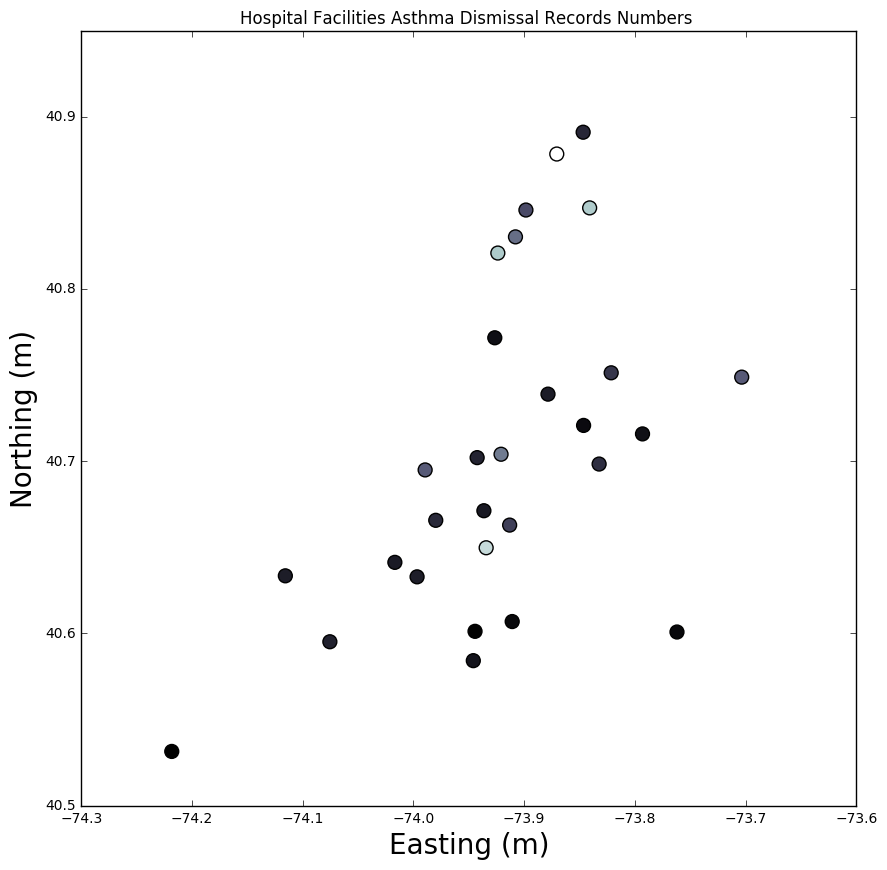

In [43]:
import pylab as pl
%pylab  inline

pl.figure(figsize=(10,10))
pl.scatter(krigdata[:,0], krigdata[:,1], c=krigdata[:,2], s=100, cmap='bone')
pl.xlabel("Easting (m)", fontsize=20)
pl.ylabel("Northing (m)", fontsize=20)
pl.title("Hospital Facilities Asthma Dismissal Records Numbers ")

# Create and try to model the semi-variogram as we did in class
# https://github.com/fedhere/UInotebooks/blob/master/kriging/kriging_porosity.ipynb
# Explain what is going on

In [ ]:
#@Review: # missing semi variogram 
#comment on what's happening, what you infer? See solution.